## Review

In [1]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.random import default_rng

In [2]:

S0 = 36
K = 40
r = 0.06
T = 1
sigma = 0.2

m = 4

dt = T / m

df = math.exp(- r * dt)
u = math.exp(sigma * math.sqrt(dt))
d = 1/u
q =( math.exp(r  * dt) - d) /(u-d)

print("df:", df)
print("u, d:", u, d)
print("q:", q)

df: 0.9851119396030626
u, d: 1.1051709180756477 0.9048374180359595
q: 0.5504603401723258


In [3]:
## Vt = df * ( q * V t+1 up + (1-q) * V t+1 down)

## assume
V_up = 3
V_down = 2

Vt = df * (q * V_up +(1-q)*V_down)

## on average, the stock grows on a risk-free rate basis.
## so Vt is df * expected future values
## here q is the risk neutral probabiliy 



In [5]:
from numpy.random import default_rng
S0 = 36
K = 40
r = 0.06
T = 1
sigma = 0.2

M = 100
I = 50000

dt = T/M
rng = default_rng(100)

Z = rng.standard_normal((M + 1, I))

S = np.zeros((M +1, I))
S[0] = S0

for t in range(1, M + 1):
    S[t] = S[t - 1] * np.exp(
        (r - 0.5 * sigma**2) * dt +
        sigma * math.sqrt(dt) * Z[t]
    )

ST = S[-1]

mu = ST.mean()
diff = mu - S0 * math.exp(r*T)
diff


np.float64(0.02637369175229054)

## Exercise

In [16]:
S0 = 36.0  # initial stock price
K = 40.0  # strike price
r = 0.06  # risk-free short rate (continuously compounded)
T = 1.0  # maturity in years
sigma = 0.2  # volatility

m = 4
dt = T / m


df = math.exp(-r * dt)  # discount factor per step
u = math.exp(sigma * math.sqrt(dt))  # up factor (CRR)
d = 1.0 / u  # down factor (CRR)

q = (math.exp(r * dt) - d) / (u - d)  # risk-neutral up probability

S_tree = np.zeros((m +1, m+1))
S_tree[0,0] = S0

z = 1

for t in range(1, m+1):
    for i in range(z):
        S_tree[i, t] = S_tree[i, t-1] * u
        S_tree[i +1, t] = S_tree[i,t-1] * d
    z += 1

np.set_printoptions(formatter={"float_kind": lambda x: f"{x:7.3f}"})
print("Stock price tree S:\n", S)

h = np.zeros_like(S)

z = 1
for t in range(m + 1):
    for i in range(z):
        h[i, t] = max(K - S_tree[i, t], 0.0)  # put payoff at node
    z += 1


V_eur = np.zeros_like(S)
V_eur[:,-1] = h[:, -1]

z = 0
for t in range(m-1, -1,-1):
    for i in range(m-z):
        cont = q* V_eur[i, t+1] +(1-q) *V_eur[i+1,t+1]
        V_eur[i,t] = df * cont
    z += 1

V_eur[0,0]

Stock price tree S:
 [[ 36.000  39.786  43.970  48.595  53.706]
 [  0.000  32.574  36.000  39.786  43.970]
 [  0.000   0.000  29.474  32.574  36.000]
 [  0.000   0.000   0.000  26.669  29.474]
 [  0.000   0.000   0.000   0.000  24.132]]


np.float64(3.9771456941187893)

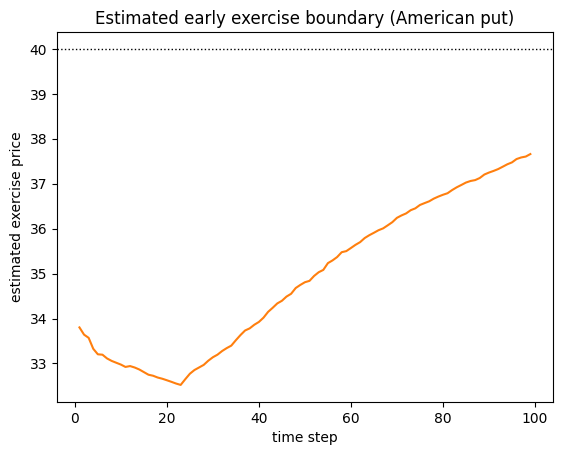

np.float64(4.400716054176611)

In [20]:
M = 100
I = 50000
dt = T / M
df = math.exp(-r * dt)

from numpy.random import default_rng
rng = default_rng(100)

rn = rng.standard_normal((M + 1, I))
S_paths = np.zeros_like(rn)
S_paths[0] = S0

for t in range(1, M + 1):
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * math.sqrt(dt) * rn[t]
    S_paths[t] = S_paths[t - 1] * np.exp(drift + diffusion)

h = np.maximum ( K-S_paths, 0) ## intrinsic values



V = h[-1].copy()  ## Terminal condition

## backwards inductions

exercise = np.zeros_like(h, dtype = bool)
exercise[-1] = h[-1] > 0

for t in range(M-1, 0,-1):
    y = df * V
    x = S_paths[t]
    reg = np.polyfit(x,y,deg=2)
    C = np.polyval(reg,x)
    ex = h[t] > C
    V = np.where(ex, h[t], df *V)
    exercise[t] = ex

V0 = df * V.mean()


boundary = np.full(M +1 , np.nan)
for t in range(1,M):
    mask = exercise[t]
    if mask.any():
        boundary[t] = np.mean(S_paths[t, mask])
        
    

fig, ax = plt.subplots()
ax.plot(boundary, color="tab:orange")
ax.axhline(K, color="k", lw=1.0, ls=":")
ax.set_xlabel("time step")
ax.set_ylabel("estimated exercise price")
ax.set_title("Estimated early exercise boundary (American put)")

plt.show()  
V0

In [22]:
diff = V0 - V_eur[0,0]
diff


np.float64(0.42357036005782156)